# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs)

## Problem 0 (45 points)

In this problem, you'll implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [33]:
from scipy.integrate import solve_ivp
from euler import ForwardEuler

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

In [34]:
import numpy as np

h = 0.01
def fun(t,y): return y
t_start = 0
t_stop = 5
t_span = (t_start,t_stop)
sol = solve_ivp(fun,t_span,y0 = np.array([1]), method = ForwardEuler, h = h)

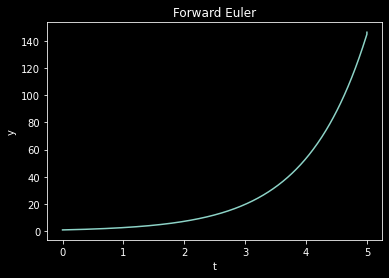

In [35]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
plt.plot(sol.t,sol.y[0])
plt.xlabel("t")
plt.ylabel("y")
plt.title("Forward Euler")
plt.show()

In [36]:
# In this block we use the dsolve function from sympy.solvers.ode
import sympy as sym
from sympy.solvers import ode
from sympy import Eq

t = sym.symbols('t')
y = sym.Function('y')
# This is the ground truth
sym_sol = ode.dsolve(eq = y(t).diff(t) - y(t), ics = {y(0):1})

# We calculate the difference for each step here
d_sym = []
for i in range(len(sol.t)):
    d_sym.append(np.abs(sym_sol.rhs.evalf(subs={t:sol.t[i]}) - sol.y[0][i]))

print(f"The max error for forward Euler comparing with sympy solver is {{}}".format(round(max(d_sym),4)))

The max error for forward Euler comparing with sympy solver is 3.6404


In [37]:
# In this block we use the solve_ivp function from scipy.integrate
import scipy.integrate
ivp_sol = scipy.integrate.solve_ivp(fun,t_span = t_span, y0 = np.array([1]),max_step = h)
d_ivp = []
for i in range(len(sol.t)):
    d_ivp.append(np.abs(ivp_sol.y[0][i] - sym_sol.rhs.evalf(subs={t:sol.t[i]})))

d_two_ivp = []
for i in range(len(sol.t)):
    d_two_ivp.append(np.abs(ivp_sol.y[0][i] - sol.y[0][i]))
print(f"The max error for ivp_solver comparing with sympy solver is {{}}".format(max(d_ivp)))
print(f"The max error for forward Euler comparing with solve_ivp is {{}}".format(max(d_two_ivp)))


The max error for ivp_solver comparing with sympy solver is 2.05773176276125E-11
The max error for forward Euler comparing with solve_ivp is 3.6403866700148626


### Part C (15 points)

Implement unit tests that verify that ODE solutions (numerically) obey the ODE.  Try this for $y'(t) = y$, with $y(0) = 1$ on the domain $t\in [0,5]$.  use a finite difference stencil with step size `k` (`k` should be smaller than the `h` you used to solve the ODE) to compute the derivative at several points.  You should only expect the derivative to be accurate to about `h*y`

Implement tests for `solve_ivp` using the default settings as well as using your `ForwardEuler` implementation.

Put these tests in [`test.py`](test.py).  Set up your unit tests to run when you push changes to GitHub using GitHub actions. In order to respect server time, set a 10 minute time-limit on your github actions workflow. To see an example of how to set a time-limit, see line 9 in the relevant file from Homework 3 by clicking [here](https://github.com/caam37830-2021/homework-3-template/blob/main/.github/workflows/push.yml).

---

*put any discussion here*

## Problem 1 (20 points)

In this problem, you'll solve two simple, but related, ODEs using `solve_ivp`.

### Part A (13 points)

On the surface of the earth, objects are accelerated by a more-or-less constant gravitational field.  We'll consider an object thrown vertically with initial position $y=y_0$, and initial velocity $y' = v_0$.

We'll consider a simplified problem with no wind resistance.  Newton's laws of motion tell us $y''(t) = -g$, where $g = 9.8 m/s^2$.  This is a second order ODE, which we can turn into a system of first order ODEs using the substituion $p = y'$.  Then we have
\begin{equation}
\begin{cases}
y'(t) = p(t)\\
p'(t) = -g
\end{cases}
\end{equation}

You can encode this using a vector $v$, where $v[0]$ is the value $y$ above, and $v[1]$ is $p$.

Use `solve_ivp` to solve for `y(t)` using `y0 = 0` and `y'(0) = 10` (i.e. you throw a ball straight up in the air at a speed of $10 m/s$).  Run this simulation for $4$ seconds.  make a plot of the trajectory $y$ as a function of $t$ (i.e. $t$ is on the horizontal axis and $y$ is on the vertical axis).  Set up an event to end the simulation when `y` is zero again (when the ball hits the ground).  At what time does the ball hit the ground?

Set up an event to find when the ball is at its highest point (`p(t) = 0`).  This should not terminate the simulation.

---

*put any answers/discussion here*

In [38]:
p = sym.Function('p')
y = sym.Function('y')

# The initial state of the system of equations
v = np.array([0,10])
# Here we are solving 2 equations, so we need to return a vector
def fun(t,v):
    """
    Takes in time t and vector v = [y(t),p(t)]

    Outputs entrywise derivative of v
    """
    # Note that we here should return the the derivative of two euqations
    # which happens to be the second entry of v for the first equation, and -9.8 for the second equation
    return np.array([v[1],-9.8])

# Time interval of solve_ivp
t_span = (0,4)
# The step size of solve_ivp
h = 0.0001
# Here we define an event such that it will terminate the silumation even when t has not reached 4
# The logic is as follows:
#
#       There are only under 2 events that v[0], which is the position of the ball, is equal to 0
#           1. The moment that the ball just started moving, i.e. t = 0, which we do not terminate the simulation
#           2. The moment that the ball hit the ground, which the time is unknow yet, so we terminate the simulation
#
# Note that whne the ball hit the ground, v[0] goes from positive to negative, because the algorithm does not
# know 0 is the lower limit. So we terminate the simulation using direction = -1.

# We need to return the position as it is the quantity we check for stopping criterion
def hit_ground(t,y): return y[0]
# We need the termination, so terminal = True
hit_ground.terminal = True
# Here -1 means the being checked quantity goes from positive to negative
hit_ground.direction = -1
# Everything is exactly the same as before, besides now we add parameter events to check for stopping criterion
ans = scipy.integrate.solve_ivp(fun,t_span = t_span, y0 = v, max_step = h, events = hit_ground)
# Recording results
position = ans.y[0]
velocity = ans.y[1]
t_sim = ans.t

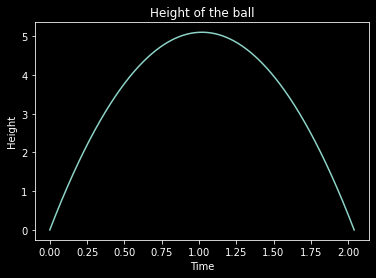

The ball hit the ground at t = 2.0408


In [39]:
plt.plot(t_sim, position)
plt.title("Height of the ball")
plt.xlabel("Time")
plt.ylabel("Height")
plt.show()
print(f"The ball hit the ground at t = {{}}".format(round(t_sim[-1],4)))

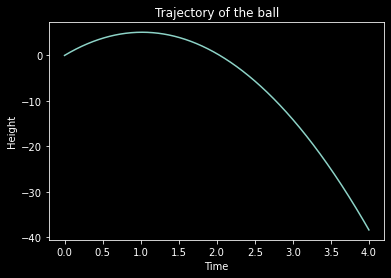

In [40]:
# In this block we make a trajectory plot
# Everything is the same besides now we do not stop when position is 0

ans = scipy.integrate.solve_ivp(fun,t_span = t_span, y0 = v, max_step = h)

plt.plot(ans.t, ans.y[0])
plt.title("Trajectory of the ball")
plt.xlabel("Time")
plt.ylabel("Height")
plt.show()

In [41]:
# In this block we will find the time at which the ball reaches the highest point

# We need to return the velocity as it is the quantity we check for stopping criterion
def hit_ground(t,y): return y[1]
# We do not terminate the simulation, so terminal = False
hit_ground.terminal = False
# Here -1 means the being checked quantity goes from positive to negative
hit_ground.direction = -1
# Everything is exactly the same as before when checking for position
ans = scipy.integrate.solve_ivp(fun,t_span = t_span, y0 = v, max_step = h, events = hit_ground)
# Our desired answer is at ans.t_events
print(f"The ball reaches the highest point at t = {{}}".format(str(ans.t_events[0])))

The ball reaches the highest point at t = [1.02040816]


### Part B (7 points)

We'll now take into account wind resistance on the ball.  We'll make a bunch of assumptions, and simply assume that the drag can be expressed as a force that accelerates the ball by adding a term `y''(t) = p'(t) = -9.8 -0.02 sgn(p(t)) p(t)**2`, where `sgn(p(t))` can be computed using `np.sign` (the sign of the velocity).

Incorporate this term into the system of ODEs, and use `solve_ivp` to plot the trajectory of the ball with the same initial conditions as in part A.  Set up an event to terminate the simulation when the ball hits the ground.  At what time does the ball hit the ground?  Is this before or after the ball hits the ground when there is no wind resistance?

Set up an event to find when the ball is at its highest point (`p(t) = 0`).  This should not terminate the simulation.

---

*put any answers/discussion here*

In [42]:
# Same initial state as before
v = np.array([0,10])
# Here we are solving 2 equations, so we need to return a vector
def fun(t,v):
    """
    Takes in time t and vector v = [y(t),p(t)]

    Outputs entrywise derivative of v
    """
    # We now change the second entry to -9.8 - 0.02*sign(p(t))*p(t)**2
    return np.array([v[1],-9.8-0.02*np.sign(v[1])*v[1]**2])

# Time interval of solve_ivp
t_span = (0,4)
# The step size of solve_ivp
h = 0.0001

# Everything is exactly the same as before
ans = scipy.integrate.solve_ivp(fun,t_span = t_span, y0 = v, max_step = h)
# Recording results
position = ans.y[0]
velocity = ans.y[1]
t_sim = ans.t

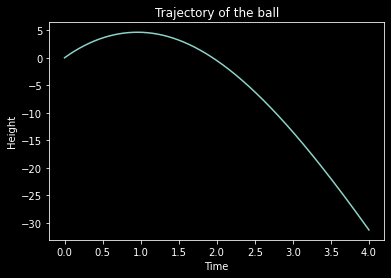

In [43]:
plt.plot(ans.t, ans.y[0])
plt.title("Trajectory of the ball")
plt.xlabel("Time")
plt.ylabel("Height")
plt.show()

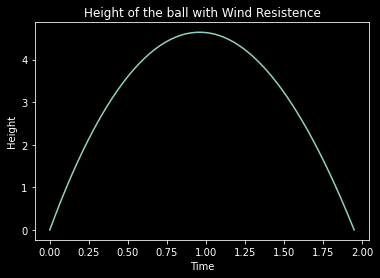

The ball hit the ground at t = 1.947


In [44]:
# Everything is the same as before
def hit_ground(t,y): return y[0]
# We need the termination, so terminal = True
hit_ground.terminal = True
# Here -1 means the being checked quantity goes from positive to negative
hit_ground.direction = -1
# Everything is exactly the same as before, besides now we add parameter events to check for stopping criterion
ans = scipy.integrate.solve_ivp(fun,t_span = t_span, y0 = v, max_step = h, events = hit_ground)
# Recording results
position = ans.y[0]
velocity = ans.y[1]
t_sim = ans.t

plt.plot(t_sim, position)
plt.title("Height of the ball with Wind Resistence")
plt.xlabel("Time")
plt.ylabel("Height")
plt.show()
print(f"The ball hit the ground at t = {{}}".format(round(t_sim[-1],4)))

In [45]:
# We need to return the velocity as it is the quantity we check for stopping criterion
def hit_ground(t,y): return y[1]
# We do not terminate the simulation, so terminal = False
hit_ground.terminal = False
# Here -1 means the being checked quantity goes from positive to negative
hit_ground.direction = -1
# Everything is exactly the same as before when checking for position
ans = scipy.integrate.solve_ivp(fun,t_span = t_span, y0 = v, max_step = h, events = hit_ground)
# Our desired answer is at ans.t_events
print(f"The ball reaches the highest point at t = {{}}".format(str(ans.t_events[0])))

The ball reaches the highest point at t = [0.95842211]


In [ ]:
"""
We can clearly see that the ball hit the ground faster than before, when had no wind resistence, which is expected for common sense.

Also, the ball reaches the highest earlier than before.
"""

## Problem 2 (25 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the trick from problem 1 to write this as 8 first order ODEs by introducing the vector-valued variables
$p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\|\\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\|\\
x_1'(t) = p_1(t)\\
x_2'(t) = p_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

In [64]:
from numba import jit
import numpy.linalg as la

# Those are the given parameters
m1 = 5.972e24
m2 = 0.07346e24
G = 6.67e-11
r = 384.4e6
Fg = G * m1 * m2 / r**2
v0 = np.array([0,0,0,3.844e8,0,0,1.022e3,0])

@jit(nopython = True)
def fun_gravity(t,v):
    """
    Takes in time t and vector v = [x1,x2,y1,y2,p1,p2,q1,q2]

    Outputs entrywise derivative of v
    """
    # Here we have lots of variables, so lets try to write them out one by one carefully instead of returning everything in a single command
    x1 = v[4]
    x2 = v[5]
    y1 = v[6]
    y2 = v[7]
    p1 = -Fg * (v[0]-v[2]) / (m1 * r)
    p2 = -Fg * (v[1]-v[3]) / (m1 * r)
    q1 = Fg * (v[0]-v[2]) / (m2 * r)
    q2 = Fg * (v[1]-v[3]) / (m2 * r)

    return np.array([x1,x2,y1,y2,p1,p2,q1,q2])

t_span = (0,5e6)
ivp_sol_gravity = scipy.integrate.solve_ivp(fun_gravity,t_span = t_span, y0 = v0, max_step = 1)

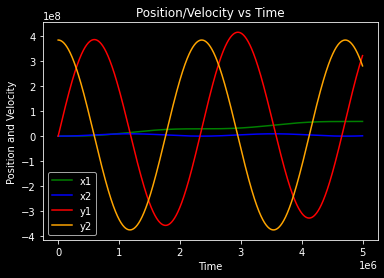

In [65]:
t_used = ivp_sol_gravity.t
x1 = ivp_sol_gravity.y[0]
x2 = ivp_sol_gravity.y[1]
y1 = ivp_sol_gravity.y[2]
y2 = ivp_sol_gravity.y[3]

plt.plot(t_used,x1,label = "x1", c = "green")
plt.plot(t_used,x2,label = "x2", c = "blue")
plt.plot(t_used,y1,label = "y1", c = "red")
plt.plot(t_used,y2,label = "y2", c = "orange")
plt.xlabel("Time")
plt.ylabel("Position and Velocity")
plt.title("Position/Velocity vs Time")
plt.legend()
plt.show()

### Part B (10 points)

The [Lorentz system](https://en.wikipedia.org/wiki/Lorenz_system) is a simplified model of atmospheric convection, which is one of the earliest systems investigated which exhibit [chaotic behavior](https://en.wikipedia.org/wiki/Chaos_theory).

\begin{equation}
\begin{cases}
dx/dt = \sigma( y - x)\\
dy/dt = x( \rho - z) - y\\
dz/dt = xy - \beta z
\end{cases}
\end{equation}

$x$ is the rate of convection, and $y$ and $z$ measure horizontal and vertical temperature variation.

You can use the parameters Lorentz used: $\sigma=10, \beta = 8/3, \rho = 28$.  
Run one simulation starting $x = y = z = 10$.  Run the simulation for $t\in [0,7]$.

Run another simulation starting at $y = z = 10$, and $x = 10.1$.  Run the simulation for $t \in [0,7]$.

Plot both solution trajectories in the $x,y$ plane (i.e. `plt(sol.y[0], sol.y[1],...`) using different colors (include labels, a title, and legend).  This system is chaotic, so the trajectories should start close and then get further apart.

---

*put any answers/discussion here*

In [48]:
# Given parameters
sigma = 10
rho = 28
beta = 8/3

@jit(nopython = True)
# v is of the form [dx/dt,dy/dt,dz/dt]
def fun_chaos(t,v):
    x = v[0]
    y = v[1]
    z = v[2]
    return np.array([sigma * (y - x), x * (rho - z) - y, x*y - beta*z])

v0 = np.array([10,10,10])
v00 = np.array([10.1,10,10])
h = 0.0001
t_span = (0,7)
ivp_sol_chaos_10 = scipy.integrate.solve_ivp(fun_chaos,t_span = t_span, y0 = v0, max_step = h)
ivp_sol_chaos_101 = scipy.integrate.solve_ivp(fun_chaos,t_span = t_span, y0 = v00, max_step = h)

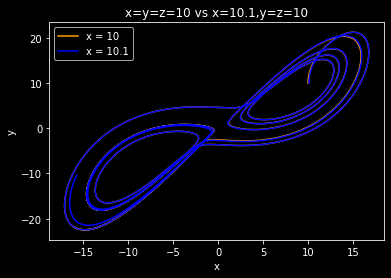

In [49]:
plt.plot(ivp_sol_chaos_10.y[0], ivp_sol_chaos_10.y[1], label = "x = 10", c = "orange")
plt.plot(ivp_sol_chaos_101.y[0], ivp_sol_chaos_101.y[1], label = "x = 10.1", c = "blue")
plt.xlabel("x")
plt.ylabel("y")
plt.title("x=y=z=10 vs x=10.1,y=z=10")
plt.legend()
plt.show()

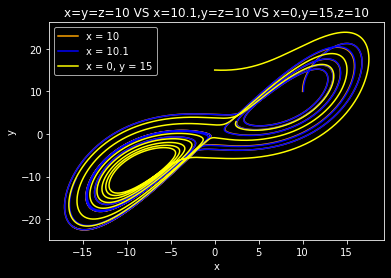

In [50]:
# There is no big difference in the above simulations, lets try to do it for v0 = [x0,y0,z0] = [0,15,10]
# Note this time we should expect to see some differences
v5 = np.array([0,15,10])
ivp_sol_chaos_5 = scipy.integrate.solve_ivp(fun_chaos,t_span = t_span, y0 = v5, max_step = h)
plt.plot(ivp_sol_chaos_10.y[0], ivp_sol_chaos_10.y[1], label = "x = 10", c = "orange")
plt.plot(ivp_sol_chaos_101.y[0], ivp_sol_chaos_101.y[1], label = "x = 10.1", c = "blue")
plt.plot(ivp_sol_chaos_5.y[0], ivp_sol_chaos_5.y[1], label = "x = 0, y = 15", c = "yellow")
plt.xlabel("x")
plt.ylabel("y")
plt.title("x=y=z=10 VS x=10.1,y=z=10 VS x=0,y=15,z=10")
plt.legend()
plt.show()

## Problem 3 (10 points)

Use functionality from `scipy.sparse` to help illustrate your answers to the following questions.

In the [class materials on differentiation](https://caam37830.github.io/book/04_functions/differentiation.html), we defined `forward_diff_matrix` and `backward_diff_matrix`.  What vectors characterize the nullspace of each of these matrices (i.e. vectors `x` so that `D @ x = 0`)?

Give an interpretation (from calculus) of the vector `y` where `y` solves the linear system `D @ y = x`, where `D` is a finite-difference matrix.  What is the implication of the nullspace of `D` on solving this linear system?

Create a finite difference operator for the Laplacian $\Delta = \partial_x^2 + \partial_y^2$ where second-order differences are based on the stencil `[1, -2, 1]`.  What is the nullspace of this matrix?

---

*Your answer here.  You can create some code cells as well*

In [51]:
import scipy.sparse as sparse
import numpy as np

"""
The purpose of the forward difference matrix is of course to use forward difference to approximate the
dirivative of a function g at each different points. Let g(t) = x. If there is an x such that D @ x = 0, 
then it means this function has all its values equal at each grid point. Assume that our grid points are 
dense enough such that they capture almost all of "features" of the function g, then this means g has its 
value all equal regardless of the evaluation points, this means that g is a constant function, i.e. g(t) = c 
for all t and constant c. Another way to say it is that g has its derivatives all equal to 0 at all points,
which implies that g is a constant function.

In this case, it is obvious that we can use a vector whose enties are all ones to represent g. i.e. the
nullspace of each of these matrices are span{1,1,1,...,1}.

We will illustrate this below.
"""

def forward_diff_matrix(n):
    """
    Takes in the dimension of the matrix n

    Returns the matrix representation (discretization) of forward difference
    """
    data = []
    i = []
    j = []
    for k in range(n - 1):
        i.append(k)
        j.append(k)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

n = 100
D = forward_diff_matrix(n)
one = np.ones(n)
D @ one

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
"""
The vector y is the pre-image of x in the linear system D @ y = x.

If the nullspace of D consists only the 0 vector, then the solution for this linear system
is unique, i.e. there is only a unique y for each x such that D @ y = x. If the nullspace of D
consists other vectors, this means the solution of the system is not unique, whihc means
there are multiple y's such that D @ y = x.
"""

In [58]:
def backward_diff_matrix(n):
    """
    Takes in the dimension of the matrix n

    Returns the matrix representation (discretization) of backward difference
    """
    data = []
    i = []
    j = []
    for k in range(1,n):
        i.append(k)
        j.append(k)
        data.append(1)

        i.append(k)
        j.append(k-1)
        data.append(-1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

# Wrote in the same fashion as in lecture notes
def laplacian(n):
    """
    Takes in the dimension of the matrix n

    Returns the matrix representation (discretization) of Laplacian operator
    """
    A = backward_diff_matrix(n)
    B = forward_diff_matrix(n)
    # Note here -B@B produces a matrix with stencil [1,-2,1] which is what we want
    # Second Partial derivative of x
    Dx = sparse.kron(sparse.eye(n), -B.T@B).tocsr()
    # Second Partial derivative of y
    Dy = sparse.kron(-B.T@B, sparse.eye(n)).tocsr()
    return Dx + Dy

In [63]:
# Lets take a look at when n = 3, whice it is easier to analyze
C = laplacian(3)
C.todense()

matrix([[-2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -3.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -2.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -3.,  1.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  1., -3.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -2.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  1., -3.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -2.]])

In [ ]:
"""
We can see that we have some -3's and -4's on the diagonals. This is a good indication that
our result is correct because the absolute value of the diagonal is telling us for that
particular point, how many partial derivatives we are able to do. For example, C[1,1] = -3
in the laplacian representing matrix is corresponding to the second point, counted by row,
so it is the 2nd point on the 1st row of the original grid (say it is G[0,1]). Now for that 
point, we can do both backward and forward differences along the row, which represents partial
of x, but we can only do forwards along the y-direction as there is no point as G[-1,1], it
is out of index. As we go further on the diagonals, we can see points has their diagonals being -4 
because both second order derivative of x and y directions are available.

Also, another indication of correctness is that since we used n = 3, the j-n and j+n entry at each row
should be 1, if not out of index. For example, for first row where i = 1, we should see that 
C[0,3] = C[1,4] = C[2,5] = 1, which is what we have.
"""

In [60]:
"""
Again, the nullspace of Laplacian operation representing matrix has its nullspace containing the vector
of all ones.
"""
C @ np.ones(C.shape[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.